# UFC 270 ПРЕДСКАЗАНИЕ

В этом блокноте я использую следующие алгоритмы построения модели:

    Gaussian Naive Bayes
    Logistic Regression
    Decision Tree
    KNN
    Random Forest
    Support Vector Classifier
    XGBoost
    Artificial Neural Network

Данные были спарсены с сайта ufcstats 31.12.2021.

После обучения модели с наивысшей оценкой точности (с использованием перекрестной проверки) применятся к предстоящему событию (23 января 2022 года), чтобы сделать прогнозы победителей поединков.

# Импорт библиотек

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

import xgboost
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers, models, optimizers

import tensorflow as tf




# Импорт и очистка данных боев для использования в моделях

In [133]:
data = pd.read_csv("data/data.csv", sep=',')

In [134]:
data.head(5)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Derrick Lewis,Chris Daukaus,Mark Smith,2021-12-18,"Las Vegas, Nevada, USA",Red,False,Heavyweight,1.500000,0.000000,...,2.0,12.0,0.0,0.0,Orthodox,190.50,200.66,260.0,32.0,36.0
1,Dustin Stoltzfus,Gerald Meerschaert,Mark Smith,2021-12-18,"Las Vegas, Nevada, USA",Blue,False,Middleweight,0.031738,0.188477,...,0.0,0.0,0.0,0.0,Orthodox,182.88,190.50,185.0,34.0,30.0
2,Stephen Thompson,Belal Muhammad,Herb Dean,2021-12-18,"Las Vegas, Nevada, USA",Blue,False,Welterweight,0.000000,0.016235,...,6.0,5.0,0.0,0.0,Orthodox,182.88,190.50,170.0,33.0,38.0
3,Amanda Lemos,Angela Hill,Jason Herzog,2021-12-18,"Las Vegas, Nevada, USA",Red,False,WomenStrawweight,0.062538,0.000000,...,1.0,2.0,1.0,0.0,Southpaw,162.56,165.10,115.0,36.0,34.0
4,Diego Ferreira,Mateusz Gamrot,Jason Herzog,2021-12-18,"Las Vegas, Nevada, USA",Blue,False,Lightweight,0.250000,0.250000,...,3.0,3.0,2.0,0.0,Orthodox,175.26,187.96,155.0,31.0,36.0


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405 entries, 0 to 6404
Columns: 144 entries, R_fighter to R_age
dtypes: bool(1), float64(118), int64(16), object(9)
memory usage: 7.0+ MB


Text(0.5, 1.0, 'Пропущенные значения')

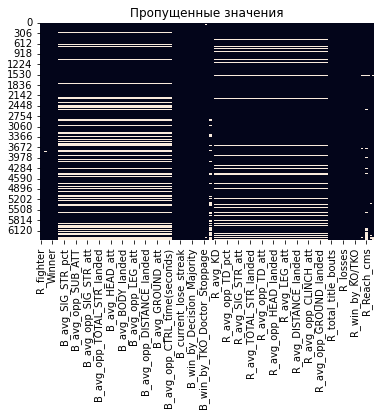

In [53]:
sns.heatmap(data.isnull(), cbar = False).set_title("Пропущенные значения")

In [54]:
data.isnull().sum()

R_fighter         0
B_fighter         0
Referee          32
date              0
location          0
               ... 
R_Height_cms     11
R_Reach_cms     408
R_Weight_lbs      9
B_age           172
R_age            70
Length: 144, dtype: int64

In [135]:
data_drop = data.loc[data['B_total_time_fought(seconds)'].isnull()]

In [136]:
data = data[~data.index.isin(data_drop.index)]

In [137]:
data_drop = data.loc[data['R_total_time_fought(seconds)'].isnull()]

In [138]:
data = data[~data.index.isin(data_drop.index)]

In [139]:
data.drop(columns=['R_Reach_cms', 'B_Reach_cms'], inplace=True)

In [140]:
m= data.R_age

In [141]:
data.fillna(data.mean(), inplace=True)

/tmp/ipykernel_32408/1087262814.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


In [142]:
data.R_age = m

In [143]:
data.R_Stance.fillna("Orthodox", inplace=True)

In [144]:
data.B_Stance.fillna("Orthodox", inplace=True)

In [145]:
data.Referee.value_counts()

Herb Dean          736
John McCarthy      410
Dan Miragliotta    335
Marc Goddard       294
Mario Yamasaki     275
                  ... 
Al Wichgers          1
Ricky Parker         1
Nick Gamst           1
Travis Metteer       1
Tony Mullinax        1
Name: Referee, Length: 193, dtype: int64

In [146]:
data.Referee.fillna("Herb Dean", inplace=True)

Text(0.5, 1.0, 'Пропущенные значения')

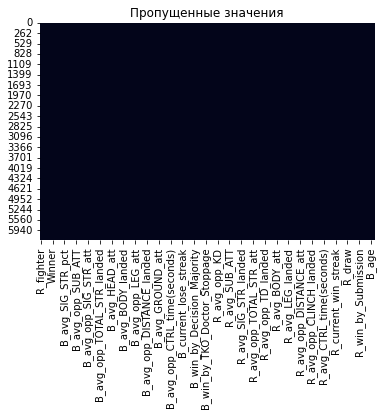

In [147]:
sns.heatmap(data.isnull(), cbar = False).set_title("Пропущенные значения")

In [68]:
data.isnull().sum()

R_fighter       0
B_fighter       0
Referee         0
date            0
location        0
               ..
R_Stance        0
R_Height_cms    0
R_Weight_lbs    0
B_age           0
R_age           0
Length: 142, dtype: int64

In [69]:
data.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Weight_lbs,B_age,R_age
0,Derrick Lewis,Chris Daukaus,Mark Smith,2021-12-18,"Las Vegas, Nevada, USA",Red,False,Heavyweight,1.500000,0.000000,...,2.0,2.0,12.0,0.0,0.0,Orthodox,190.50,260.0,32.0,36.0
1,Dustin Stoltzfus,Gerald Meerschaert,Mark Smith,2021-12-18,"Las Vegas, Nevada, USA",Blue,False,Middleweight,0.031738,0.188477,...,0.0,0.0,0.0,0.0,0.0,Orthodox,182.88,185.0,34.0,30.0
2,Stephen Thompson,Belal Muhammad,Herb Dean,2021-12-18,"Las Vegas, Nevada, USA",Blue,False,Welterweight,0.000000,0.016235,...,0.0,6.0,5.0,0.0,0.0,Orthodox,182.88,170.0,33.0,38.0
3,Amanda Lemos,Angela Hill,Jason Herzog,2021-12-18,"Las Vegas, Nevada, USA",Red,False,WomenStrawweight,0.062538,0.000000,...,0.0,1.0,2.0,1.0,0.0,Southpaw,162.56,115.0,36.0,34.0
4,Diego Ferreira,Mateusz Gamrot,Jason Herzog,2021-12-18,"Las Vegas, Nevada, USA",Blue,False,Lightweight,0.250000,0.250000,...,0.0,3.0,3.0,2.0,0.0,Orthodox,175.26,155.0,31.0,36.0


In [108]:
data.Referee.value_counts()

Herb Dean          761
John McCarthy      410
Dan Miragliotta    335
Marc Goddard       294
Mario Yamasaki     275
                  ... 
Al Wichgers          1
Ricky Parker         1
Nick Gamst           1
Travis Metteer       1
Tony Mullinax        1
Name: Referee, Length: 193, dtype: int64

In [70]:
data.Winner.value_counts()

Red     2940
Blue    1628
Draw      82
Name: Winner, dtype: int64

In [71]:
""""
def get_renamed_winner(row):
    if row['Winner']== "Red":
        return row['R_fighter']
    elif row['Winner']=="Blue":
        return row['B_fighter']
    elif row['Winner'] == 'Draw':
        return 'Draw'

data2['Winner'] = data2[['R_fighter', 'B_fighter', 'Winner']].apply(get_renamed_winner, axis=1)
"""

'"\ndef get_renamed_winner(row):\n    if row[\'Winner\']== "Red":\n        return row[\'R_fighter\']\n    elif row[\'Winner\']=="Blue":\n        return row[\'B_fighter\']\n    elif row[\'Winner\'] == \'Draw\':\n        return \'Draw\'\n\ndata2[\'Winner\'] = data2[[\'R_fighter\', \'B_fighter\', \'Winner\']].apply(get_renamed_winner, axis=1)\n'

In [148]:

def get_renamed_winner(row):
    if row['Winner']== "Red":
        return 1
    elif row['Winner']=="Blue":
        return 0
    elif row['Winner'] == 'Draw':
        return 2

data['Winner'] = data[['R_fighter', 'B_fighter', 'Winner']].apply(get_renamed_winner, axis=1)

In [149]:
data.head(5)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Weight_lbs,B_age,R_age
0,Derrick Lewis,Chris Daukaus,Mark Smith,2021-12-18,"Las Vegas, Nevada, USA",1,False,Heavyweight,1.500000,0.000000,...,2.0,2.0,12.0,0.0,0.0,Orthodox,190.50,260.0,32.0,36.0
1,Dustin Stoltzfus,Gerald Meerschaert,Mark Smith,2021-12-18,"Las Vegas, Nevada, USA",0,False,Middleweight,0.031738,0.188477,...,0.0,0.0,0.0,0.0,0.0,Orthodox,182.88,185.0,34.0,30.0
2,Stephen Thompson,Belal Muhammad,Herb Dean,2021-12-18,"Las Vegas, Nevada, USA",0,False,Welterweight,0.000000,0.016235,...,0.0,6.0,5.0,0.0,0.0,Orthodox,182.88,170.0,33.0,38.0
3,Amanda Lemos,Angela Hill,Jason Herzog,2021-12-18,"Las Vegas, Nevada, USA",1,False,WomenStrawweight,0.062538,0.000000,...,0.0,1.0,2.0,1.0,0.0,Southpaw,162.56,115.0,36.0,34.0
4,Diego Ferreira,Mateusz Gamrot,Jason Herzog,2021-12-18,"Las Vegas, Nevada, USA",0,False,Lightweight,0.250000,0.250000,...,0.0,3.0,3.0,2.0,0.0,Orthodox,175.26,155.0,31.0,36.0


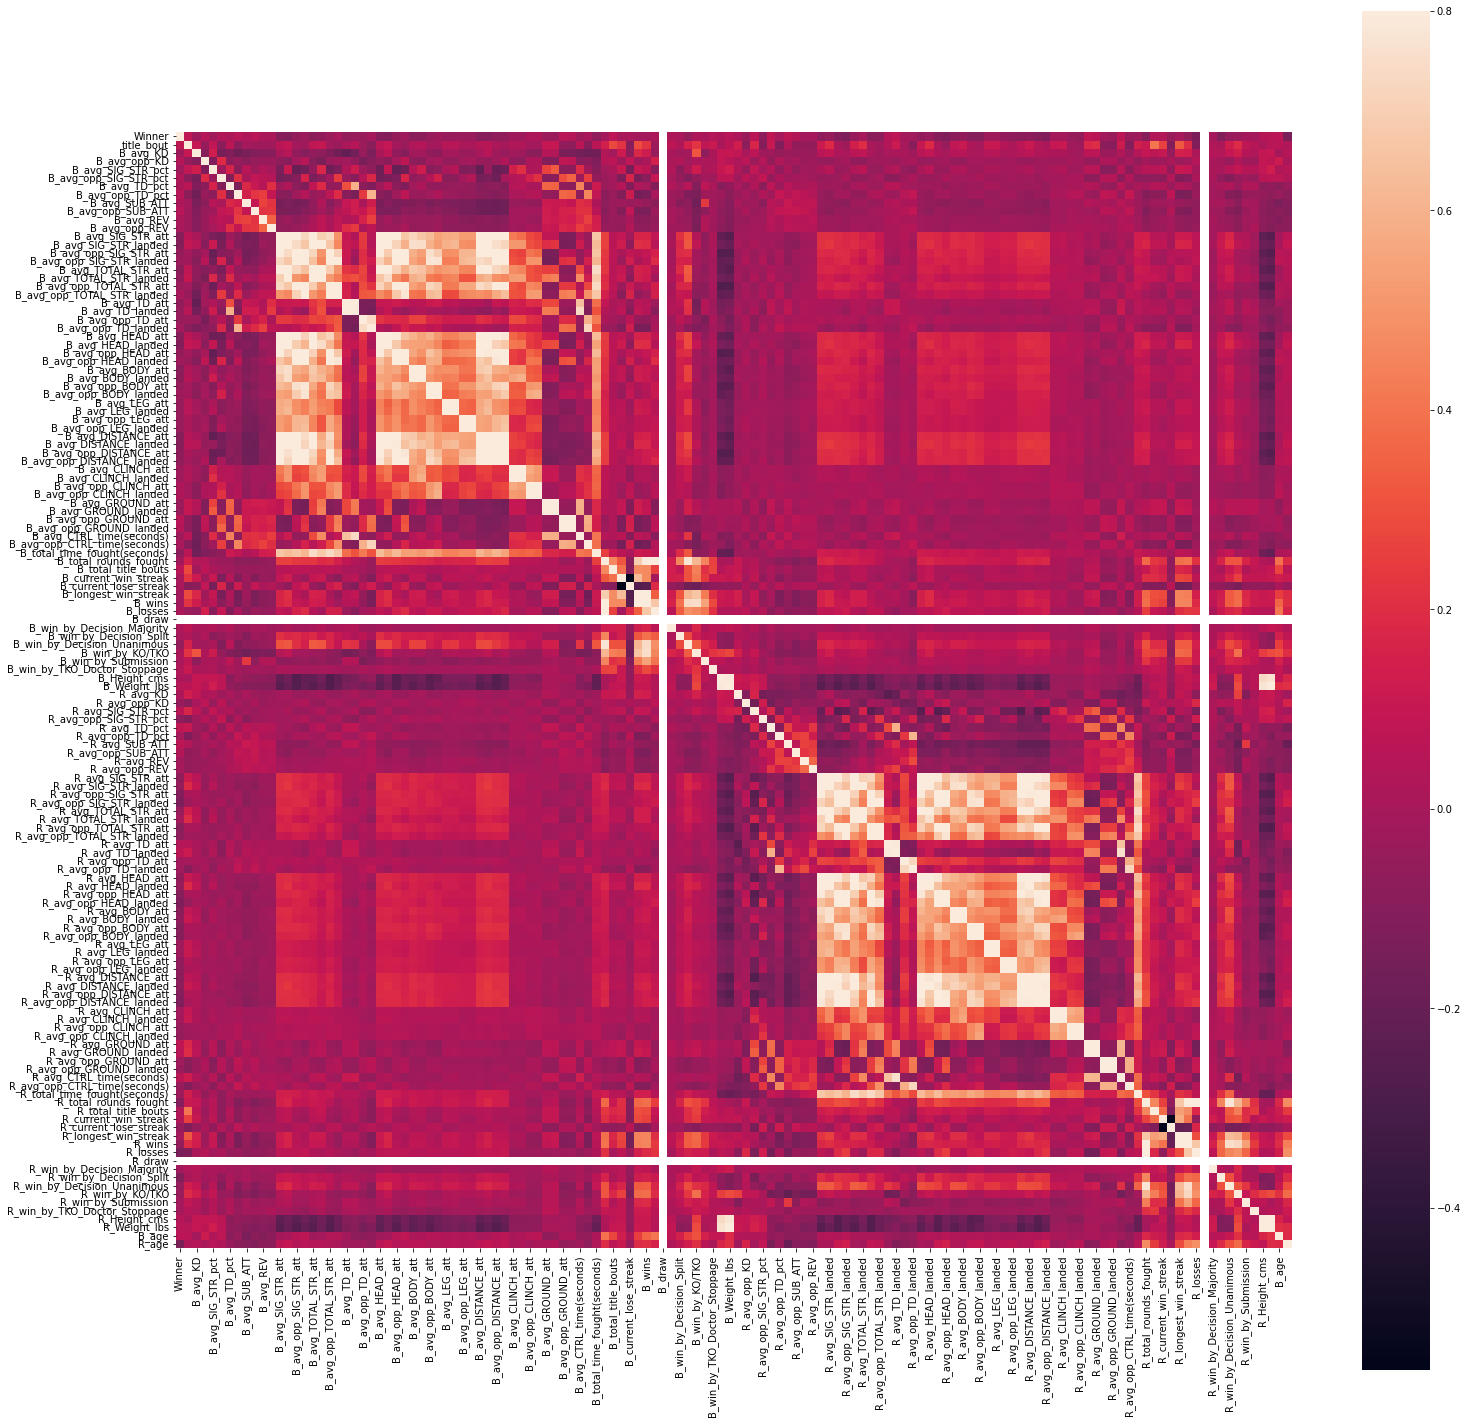

In [150]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(corrmat, vmax=.8, square=True);

In [151]:

features = data.copy()
features.drop(columns=["R_fighter","B_fighter", "Referee"], inplace=True)
numeric_subset = data.select_dtypes('number')
# Select the categorical columns
categorical_subset = data[["R_Stance", "B_Stance"]]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

In [152]:
features.head(5)

,Winner,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,...,R_age,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch
0,1,1.500000,0.000000,0.503750,0.376250,0.000000,0.000000,0.000000,0.000000,0.000000,...,36.0,0,1,0,0,0,1,0,0,0
1,0,0.031738,0.188477,0.530568,0.476453,0.186760,0.277686,0.806885,0.012207,0.276855,...,30.0,0,1,0,0,0,0,0,1,0
2,0,0.000000,0.016235,0.366433,0.408542,0.044116,0.035781,0.035156,0.000977,0.000000,...,38.0,0,1,0,0,0,1,0,0,0
3,1,0.062538,0.000000,0.518342,0.410906,0.247898,0.220654,0.035156,0.000992,0.000008,...,34.0,0,0,1,0,0,1,0,0,0
4,0,0.250000,0.250000,0.755000,0.157500,0.427500,0.000000,0.500000,0.000000,0.000000,...,36.0,0,1,0,0,0,0,0,1,0


In [153]:
X = features.drop(columns = 'Winner')
y = features[['Winner']]

In [154]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [156]:
X_test.head()

,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,...,R_age,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch
2177,0.507812,0.007812,0.368203,0.409687,0.039062,0.202266,0.187500,0.000000,0.00000,0.007812,...,27.0,0,0,1,0,0,1,0,0,0
421,1.050781,0.000000,0.528477,0.420781,0.000000,0.009570,0.132812,0.000000,0.00000,0.062500,...,38.0,0,1,0,0,0,0,0,0,1
33,0.250000,0.000000,0.318750,0.727500,0.000000,0.082500,0.000000,1.500000,0.00000,0.000000,...,25.0,0,1,0,0,0,0,0,1,0
3282,0.000000,0.250000,0.447500,0.397500,0.687500,0.125000,0.500000,0.250000,0.25000,0.000000,...,30.0,0,1,0,0,0,1,0,0,0
607,0.062622,0.378906,0.372040,0.471109,0.268442,0.031776,0.002579,0.157181,0.03125,0.000000,...,31.0,0,1,0,0,0,1,0,0,0


In [157]:
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                            colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)
print('XGB accuracy score for train: %.3f: test: %.3f' % (
    accuracy_score(y_train, y_train_preds),
    accuracy_score(y_test, y_test_preds)))

/home/sergei/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:01:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB accuracy score for train: 1.000: test: 0.656


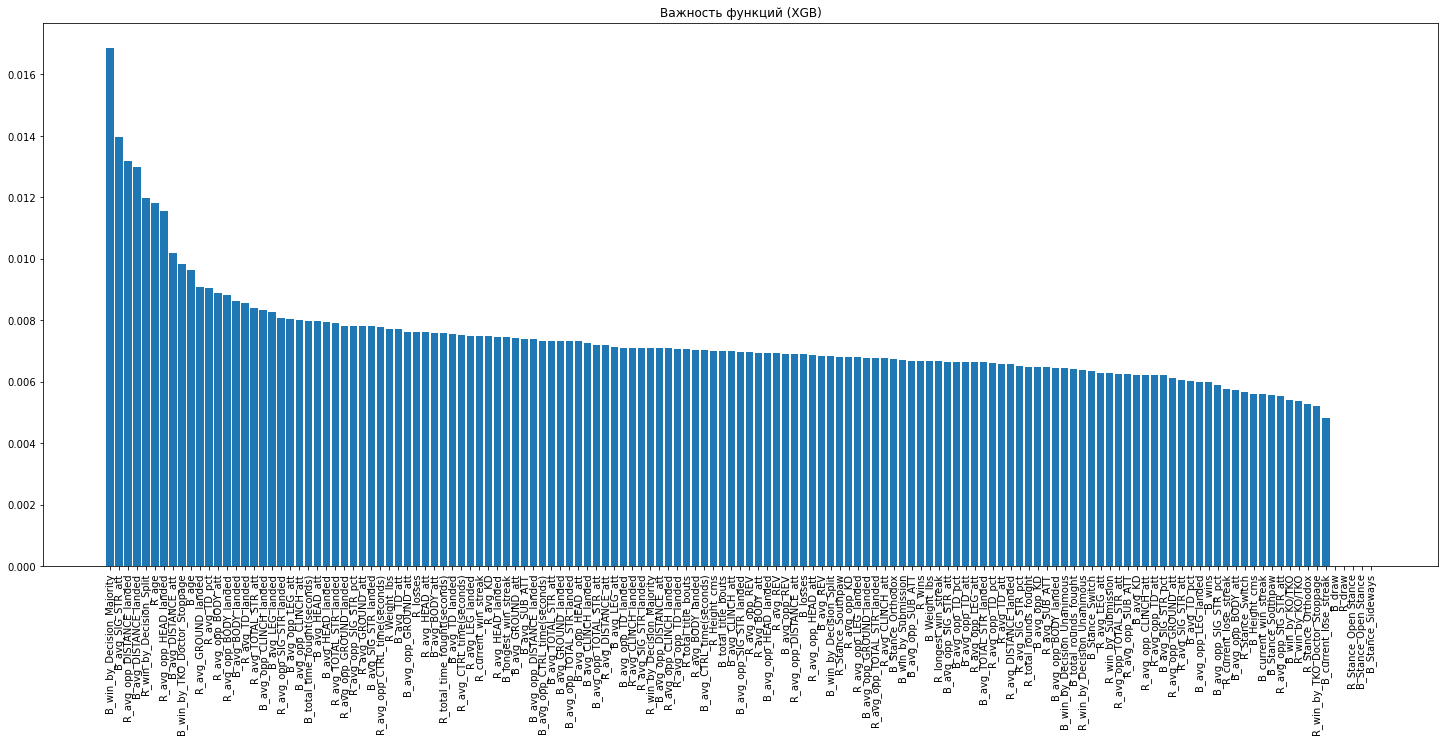

In [158]:
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)
plt.figure(figsize=(25,10))
x_pos = np.arange(0, len(xgb_feature_importances['score']))
plt.bar(x_pos, xgb_feature_importances['score']  )
plt.xticks(x_pos, xgb_feature_importances['name'])
#plt.xticks(x_pos, xgb_feature_importances[(xgb_feature_importances.name) | (xgb_feature_importances.score > 0.002)])
plt.xticks(rotation=90)
plt.title('Важность функций (XGB)')

plt.show()

In [159]:
featuresR= features[(features.Winner == 1) | (features.Winner == 0)]

In [160]:
featuresR.head(5)

,Winner,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,...,R_age,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch
0,1,1.500000,0.000000,0.503750,0.376250,0.000000,0.000000,0.000000,0.000000,0.000000,...,36.0,0,1,0,0,0,1,0,0,0
1,0,0.031738,0.188477,0.530568,0.476453,0.186760,0.277686,0.806885,0.012207,0.276855,...,30.0,0,1,0,0,0,0,0,1,0
2,0,0.000000,0.016235,0.366433,0.408542,0.044116,0.035781,0.035156,0.000977,0.000000,...,38.0,0,1,0,0,0,1,0,0,0
3,1,0.062538,0.000000,0.518342,0.410906,0.247898,0.220654,0.035156,0.000992,0.000008,...,34.0,0,0,1,0,0,1,0,0,0
4,0,0.250000,0.250000,0.755000,0.157500,0.427500,0.000000,0.500000,0.000000,0.000000,...,36.0,0,1,0,0,0,0,0,1,0


In [173]:
X = featuresR.drop(columns = 'Winner')
y = featuresR[['Winner']]

In [174]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [176]:
X_test.head()

,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,...,R_age,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch
2001,1.00,0.0,0.81000,0.3300,0.0000,0.0000,0.000,0.00,0.000,0.0,...,26.0,0,0,0,1,0,0,0,1,0
23,0.25,0.0,0.63875,0.5650,0.8250,0.3325,2.625,0.75,1.125,1.0,...,36.0,0,0,1,0,0,1,0,0,0
302,0.00,0.0,1.00000,0.0000,0.5000,0.0000,0.000,0.00,0.000,0.0,...,25.0,0,0,1,0,0,0,0,1,0
3493,0.00,0.5,0.66500,0.7500,0.5400,0.0000,0.000,0.50,0.000,0.0,...,25.0,0,1,0,0,0,1,0,0,0
5340,0.00,0.0,0.39500,0.5375,0.6025,0.1650,0.000,3.25,0.000,0.0,...,31.0,0,0,1,0,0,0,0,1,0


In [177]:
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                            colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)
print('XGB accuracy score for train: %.3f: test: %.3f' % (
    accuracy_score(y_train, y_train_preds),
    accuracy_score(y_test, y_test_preds)))

/home/sergei/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:03:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB accuracy score for train: 1.000: test: 0.637


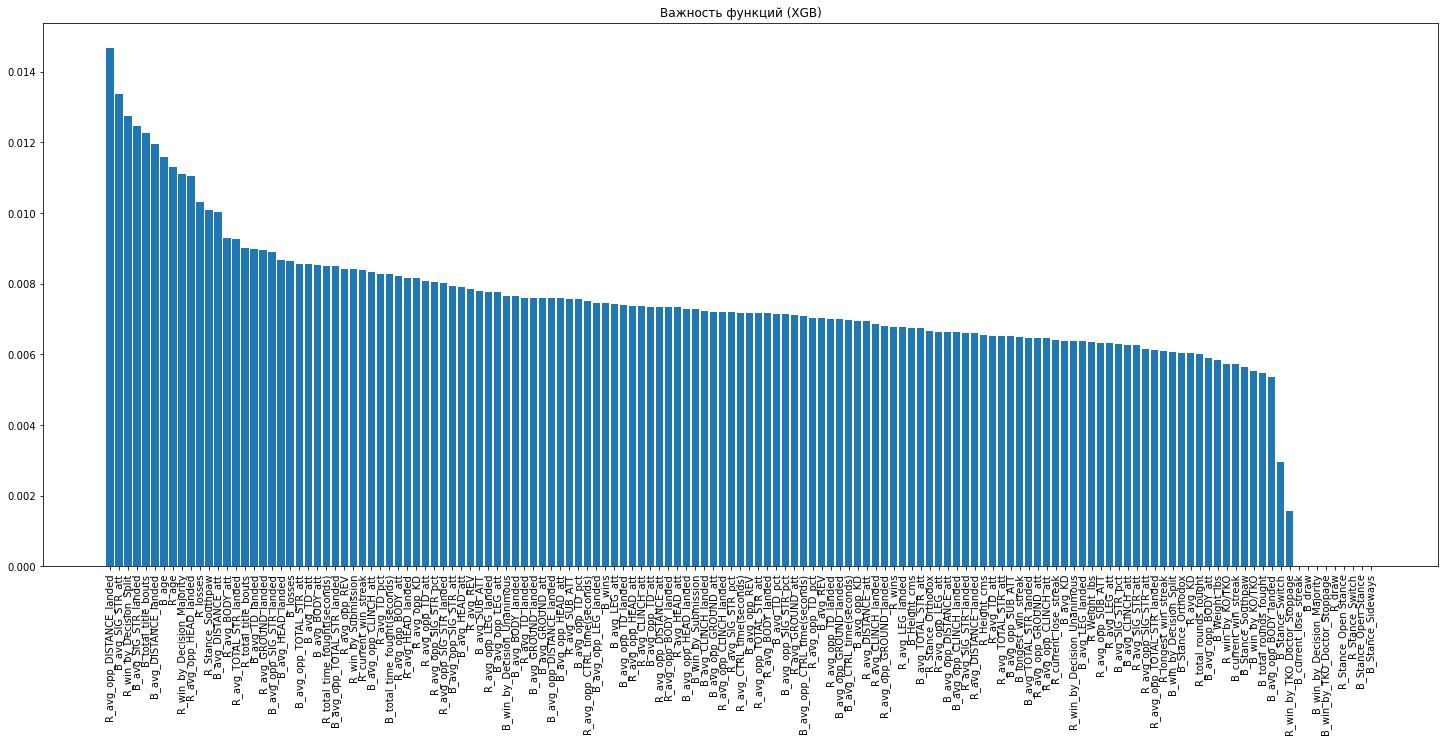

In [178]:
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)
plt.figure(figsize=(25,10))
x_pos = np.arange(0, len(xgb_feature_importances['score']))
plt.bar(x_pos, xgb_feature_importances['score']  )
plt.xticks(x_pos, xgb_feature_importances['name'])
#plt.xticks(x_pos, xgb_feature_importances[(xgb_feature_importances.name) | (xgb_feature_importances.score > 0.002)])
plt.xticks(rotation=90)
plt.title('Важность функций (XGB)')

plt.show()

In [195]:
featuresR["R_total_title_bouts"].describe()

count    4568.000000
mean        0.733363
std         1.717211
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        16.000000
Name: R_total_title_bouts, dtype: float64

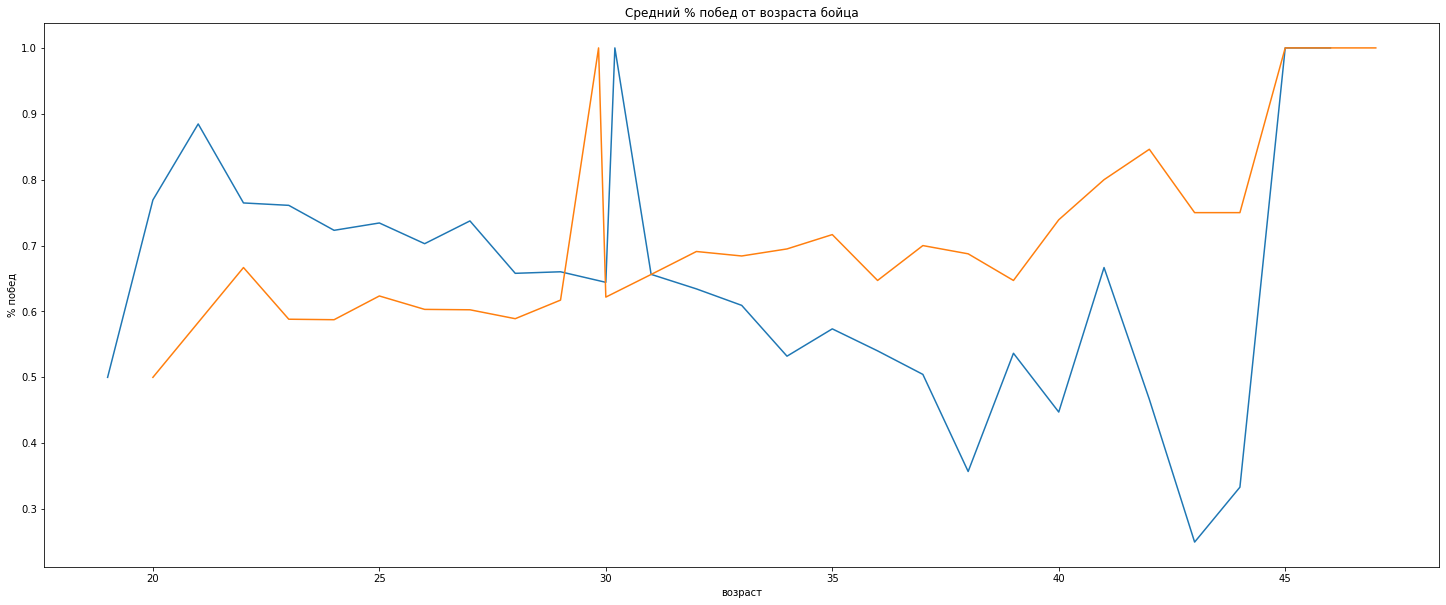

In [190]:
df_temp = featuresR.copy()

#df_temp['R_age'] = pd.qcut(df_temp['R_age'], 5000, labels=False, duplicates = 'drop')
mean_R = df_temp.groupby(['R_age'])['Winner'].mean()
mean_B = df_temp.groupby(['B_age'])['Winner'].mean()

plt.figure(figsize=(25,10))
plt.plot(mean_R.index, mean_R.values)
plt.plot(mean_B.index, mean_B.values)
plt.title('Средний % побед от возраста бойца')
plt.xlabel('возраст')
plt.ylabel('% побед')
plt.show()

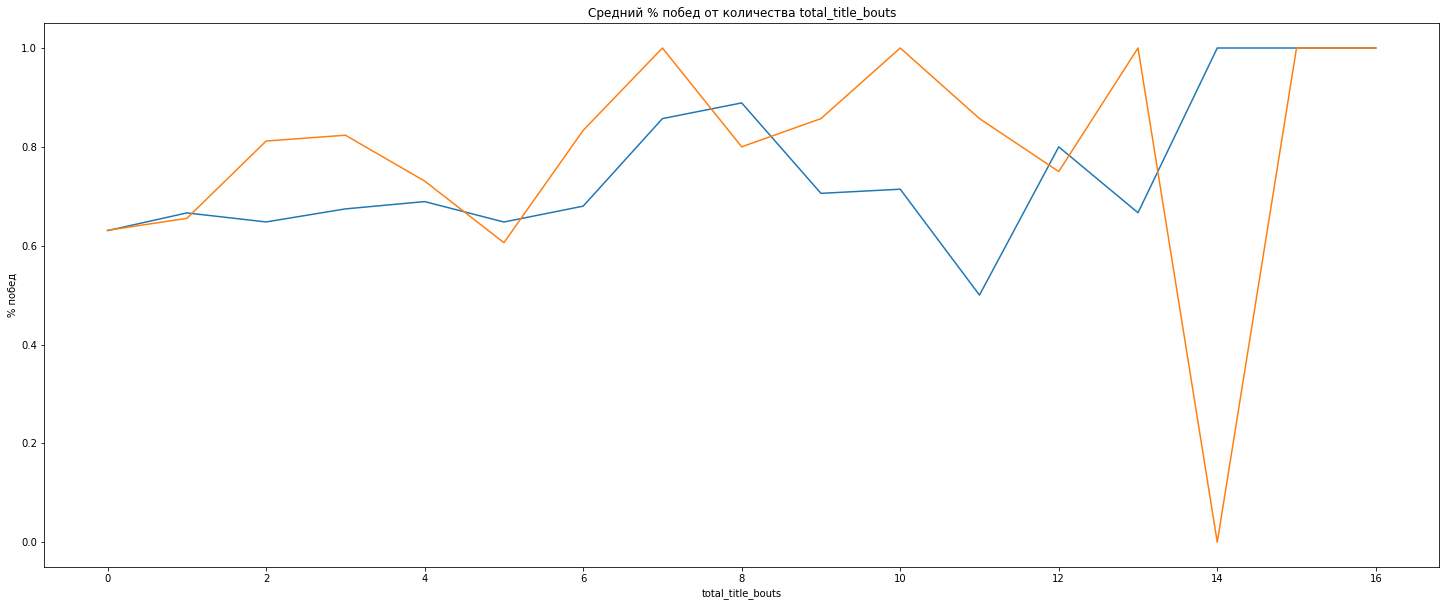

In [200]:
df_temp = featuresR.copy()

mean_R = df_temp.groupby(['R_total_title_bouts'])['Winner'].mean()
mean_B = df_temp.groupby(['B_total_title_bouts'])['Winner'].mean()

plt.figure(figsize=(25,10))
plt.plot(mean_R.index, mean_R.values)
plt.plot(mean_B.index, mean_B.values)
plt.title('Средний % побед от количества total_title_bouts')
plt.xlabel('total_title_bouts')
plt.ylabel('% побед')
plt.show()

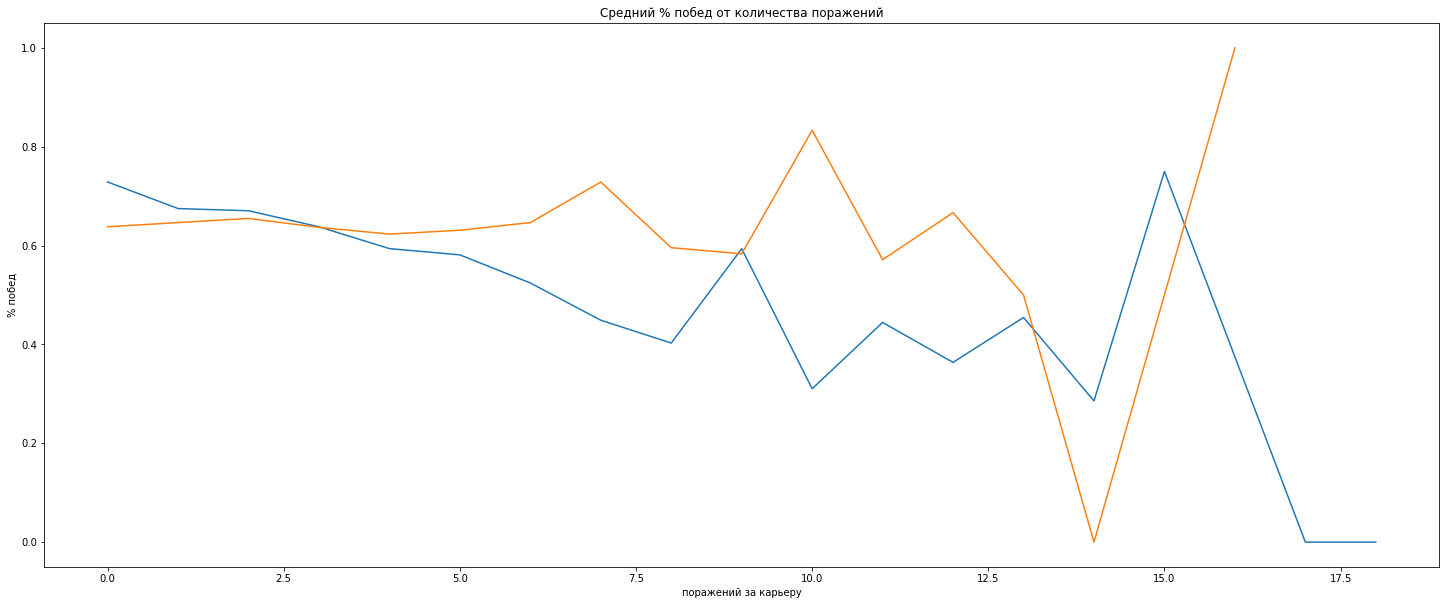

In [197]:
df_temp = featuresR.copy()

#df_temp['R_age'] = pd.qcut(df_temp['R_age'], 5000, labels=False, duplicates = 'drop')
mean_R = df_temp.groupby(['R_losses'])['Winner'].mean()
mean_B = df_temp.groupby(['B_losses'])['Winner'].mean()

plt.figure(figsize=(25,10))
plt.plot(mean_R.index, mean_R.values)
plt.plot(mean_B.index, mean_B.values)
plt.title('Средний % побед от количества поражений')
plt.xlabel('поражений за карьеру')
plt.ylabel('% побед')
plt.show()